# **Project code: PRAICP-1004-RainfallTS**

## **Project team id: PTID-AI-NOV-24-1060**

## **Project name: Rainfall Timeseries**


# **Problem statement**:

## **Rainfall Time Series**

- The data provided is recorded at the Changi Climate Station from January 1982 to June 2020.

- As a Data Scientist, you need to create a model working on this time-series data, predicting the total_rainfall for upcoming next 6 months.

- Dataset of rainfall data available from Changi airport, Singapore for a period of **924** records for each of the following **since 1980 to 2020**
  1. Monthly highest daily rainfall
  2. Monthly number of rainy days
  3. Total rainfall monthly


# Setup and Load Data

- Mount Google Drive and unzipped the dataset if necessary.
- Imports
- Define global paths and classes


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
import random

# Tqdm for progress bars
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.keras import TqdmCallback
from tqdm import tqdm

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from keras_tuner import Hyperband
import pickle

In [4]:
# Create read and working folders
base_dir = "/content/drive/MyDrive/Trials/RainfallTS/"

data_dir = os.path.join(base_dir, "Data")
meta_dir = os.path.join(base_dir, "Runtime")

model_save_path = os.path.join(meta_dir, "model.weights.best.hdf5")
history_save_path = os.path.join(meta_dir, "model_history.pkl")

# Create the directory if it doesn't exist
os.makedirs(meta_dir, exist_ok=True)

In [7]:
# Read the CSV files from the drive
df1 = pd.read_csv(
    os.path.join(data_dir, "/content/rainfall-monthly-highest-daily-total.csv")
)
df2 = pd.read_csv(
    os.path.join(data_dir, "/content/rainfall-monthly-number-of-rain-days.csv")
)
df3 = pd.read_csv(os.path.join(data_dir, "/content/rainfall-monthly-total.csv"))

# Display the first few rows of each dataframe to verify
print("Monthly Highest Daily Rainfall:")
print(df1.head())
print("\nMonthly Number of Rainy Days:")
print(df2.head())
print("\nMonthly Total Rainfall (first records):")
print(df3.head())
print("\nMonthly Total Rainfall (last records):")
print(df3.tail())

Monthly Highest Daily Rainfall:
     month  maximum_rainfall_in_a_day
0  1982-01                       36.5
1  1982-02                        9.4
2  1982-03                       61.7
3  1982-04                       45.1
4  1982-05                       33.0

Monthly Number of Rainy Days:
     month  no_of_rainy_days
0  1982-01                10
1  1982-02                 5
2  1982-03                11
3  1982-04                14
4  1982-05                10

Monthly Total Rainfall (first records):
     month  total_rainfall
0  1982-01           107.1
1  1982-02            27.8
2  1982-03           160.8
3  1982-04           157.0
4  1982-05           102.2

Monthly Total Rainfall (last records):
       month  total_rainfall
457  2020-02            65.0
458  2020-03           108.8
459  2020-04           188.0
460  2020-05           255.6
461  2020-06           233.8


In [8]:
# Create dataframe with month as index.

# Merge dataframes
df = pd.merge(df1, df2, on="month")
df = pd.merge(df, df3, on="month")

# Set 'month' as index
df["month"] = pd.to_datetime(df["month"])
df.set_index("month", inplace=True)
df.head()

,maximum_rainfall_in_a_day,no_of_rainy_days,total_rainfall
month,,,
1982-01-01,36.5,10,107.1
1982-02-01,9.4,5,27.8
1982-03-01,61.7,11,160.8
1982-04-01,45.1,14,157.0
1982-05-01,33.0,10,102.2


# Exploratory Data Analysis & Prepare Data

- Analyze and manipulate datasets to prepare for model creation


In [9]:
# Check if there are missing values
print(df.isnull().sum())

# If there are missing values, handle them (e.g., interpolation)
df = df.interpolate()
df.head()
df.shape

maximum_rainfall_in_a_day    0
no_of_rainy_days             0
total_rainfall               0
dtype: int64


(462, 3)

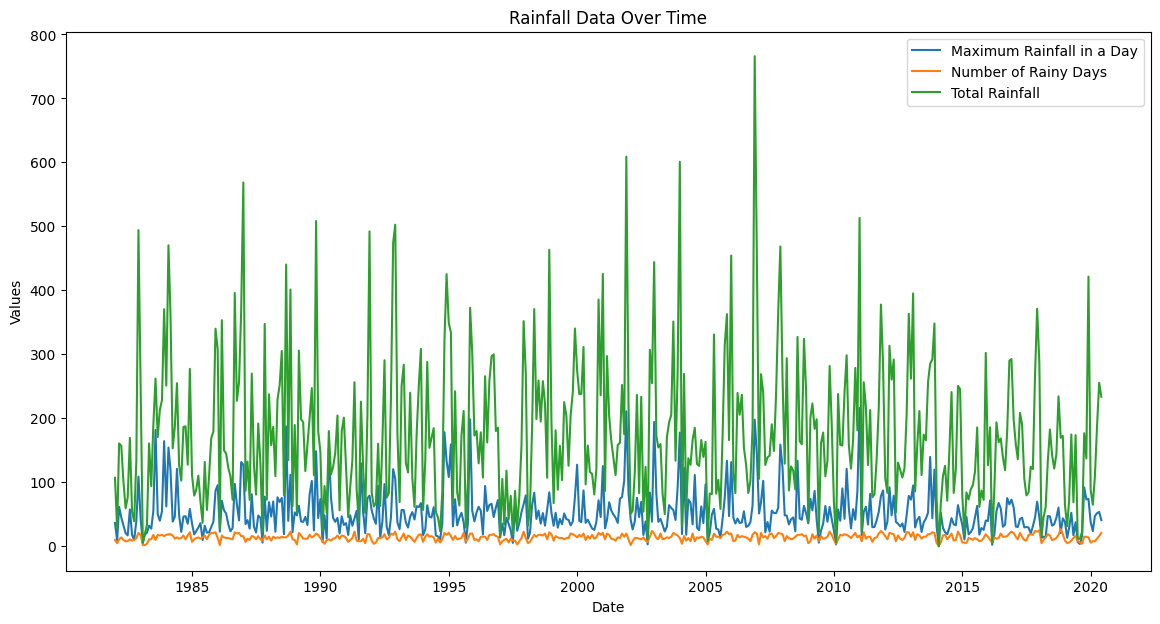

In [10]:
# Plot the cleaned data in timeline graph
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["maximum_rainfall_in_a_day"], label="Maximum Rainfall in a Day")
plt.plot(df.index, df["no_of_rainy_days"], label="Number of Rainy Days")
plt.plot(df.index, df["total_rainfall"], label="Total Rainfall")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.title("Rainfall Data Over Time")
plt.show()

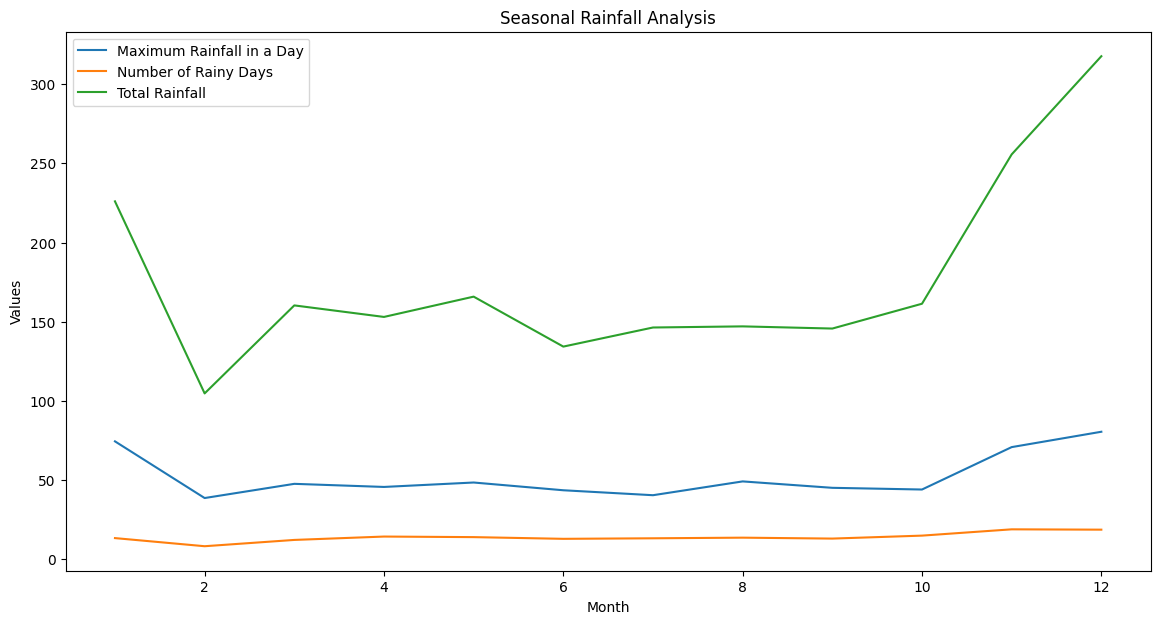

In [11]:
# Analyze to find the season months ranges
# Find which months do have highest rainfall and which have the driest
# Derive the seasonal patterns to be used later - lags and season beginning month
# Example: Dec to March highest rainfall, June to Sept driest
df["month_num"] = df.index.month
seasonal_analysis = df.groupby("month_num").mean()

plt.figure(figsize=(14, 7))
plt.plot(
    seasonal_analysis.index,
    seasonal_analysis["maximum_rainfall_in_a_day"],
    label="Maximum Rainfall in a Day",
)
plt.plot(
    seasonal_analysis.index,
    seasonal_analysis["no_of_rainy_days"],
    label="Number of Rainy Days",
)
plt.plot(
    seasonal_analysis.index, seasonal_analysis["total_rainfall"], label="Total Rainfall"
)
plt.xlabel("Month")
plt.ylabel("Values")
plt.legend()
plt.title("Seasonal Rainfall Analysis")
plt.show()

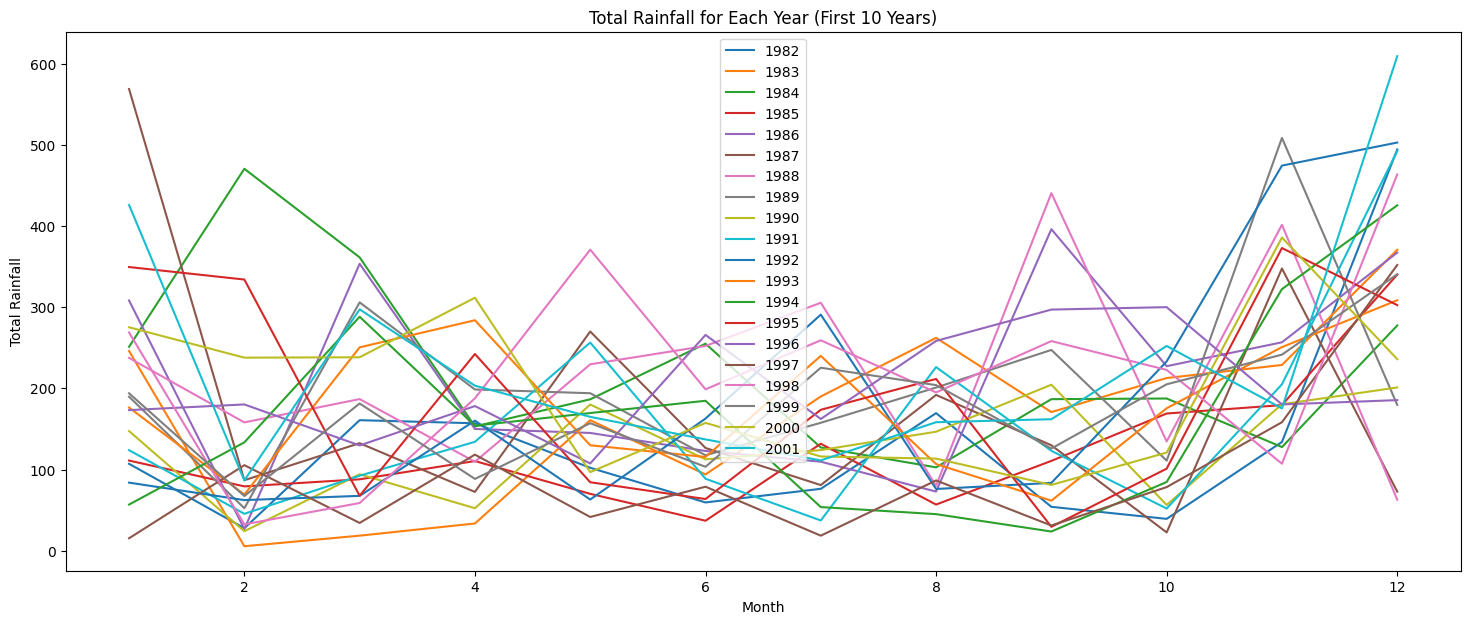

In [12]:
# Deeper understanding of data validity over months - understand is there is abormal variations
# Overlap "total rainfall" chart for every year for the first 10 years from months 1-12
plt.figure(figsize=(18, 7))
for year in df.index.year.unique()[:20]:
    yearly_data = df[df.index.year == year]["total_rainfall"]
    plt.plot(range(1, 13), yearly_data, label=f"{year}")
plt.xlabel("Month")
plt.ylabel("Total Rainfall")
plt.legend()
plt.title("Total Rainfall for Each Year (First 10 Years)")
plt.show()

In [13]:
# 2. List the standard deviation and mean of each month's "total rainfall" from the mean
monthly_stats = df.groupby(df.index.month)["total_rainfall"].agg(["mean", "std"])
print("\nMean and Standard Deviation of Total Rainfall for Each Month:")
print(monthly_stats)


Mean and Standard Deviation of Total Rainfall for Each Month:
             mean         std
month                        
1      225.987179  152.776018
2      104.735897  107.013680
3      160.294872  103.165817
4      153.017949   67.745161
5      165.828205   75.291528
6      134.287179   65.736780
7      146.344737   72.475478
8      147.052632   70.471883
9      145.681579   93.179405
10     161.350000   82.697896
11     255.626316  104.173213
12     317.613158  144.636919


# **Mean Analysis:**

## Highest Mean Rainfall: December (317.61 mm) and January (225.99 mm) show the highest mean rainfall. This indicates that these months typically experience more rainfall compared to other months.

## Lowest Mean Rainfall: February (104.74 mm) has the lowest mean rainfall, suggesting that it is the driest month on average.

# **Standard Deviation (STD) Analysis:**

## High STD: January (152.78 mm), December (144.64 mm), and February (107.01 mm) have the highest standard deviations, indicating significant variability in rainfall during these months. This means that the rainfall can vary greatly from year to year, with some years experiencing extremely high rainfall and others much lower.

## Low STD: April (67.75 mm), May (75.29 mm), and June (65.74 mm) have the lowest standard deviations, suggesting more consistent rainfall patterns during these months with less year-to-year variation.

# **Key Insights:**

## Seasonal Patterns: The high mean and high variability in January and December suggest these months may be influenced by monsoon or seasonal weather patterns, contributing to significant year-to-year changes in rainfall.

## Dry and Stable Months: February, despite its low mean rainfall, has a relatively high standard deviation, indicating that while it is generally dry, it can occasionally experience spikes in rainfall. Conversely, months like April, May, and June are not only moderate in rainfall but also more stable, with less variability.


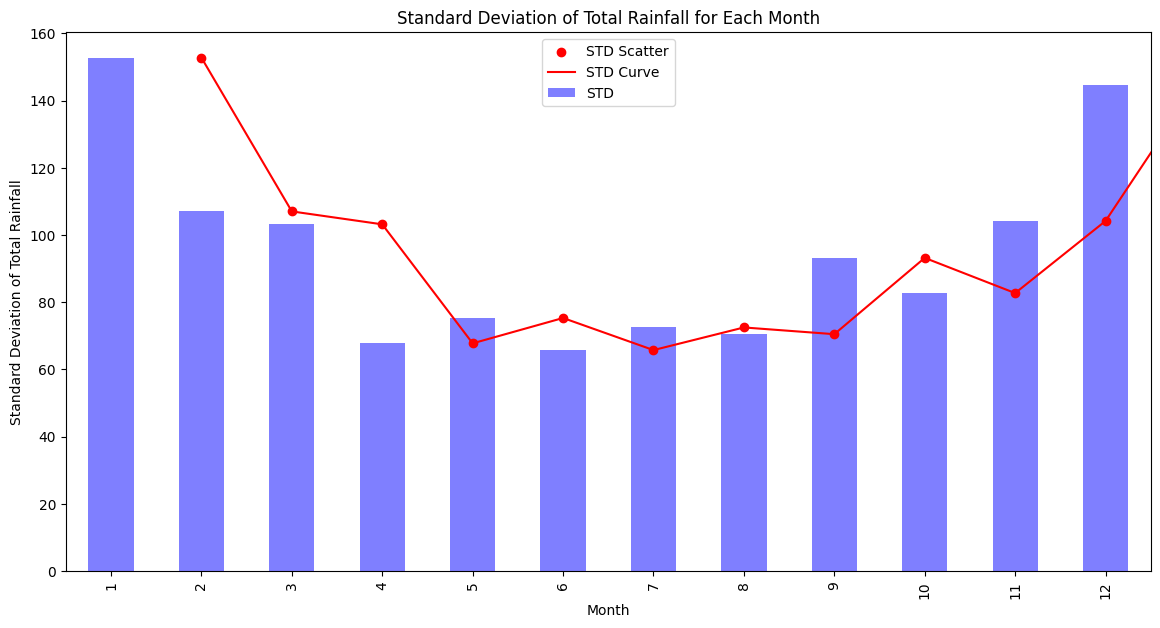

In [14]:
# Standard Deviation Plot with Curve and Scatter
plt.figure(figsize=(14, 7))
monthly_stats["std"].plot(kind="bar", alpha=0.5, label="STD", color="blue")
plt.scatter(monthly_stats.index, monthly_stats["std"], color="red", label="STD Scatter")
plt.plot(monthly_stats.index, monthly_stats["std"], color="red", label="STD Curve")
plt.xlabel("Month")
plt.ylabel("Standard Deviation of Total Rainfall")
plt.title("Standard Deviation of Total Rainfall for Each Month")
plt.legend()
plt.show()

<Figure size 1400x700 with 0 Axes>

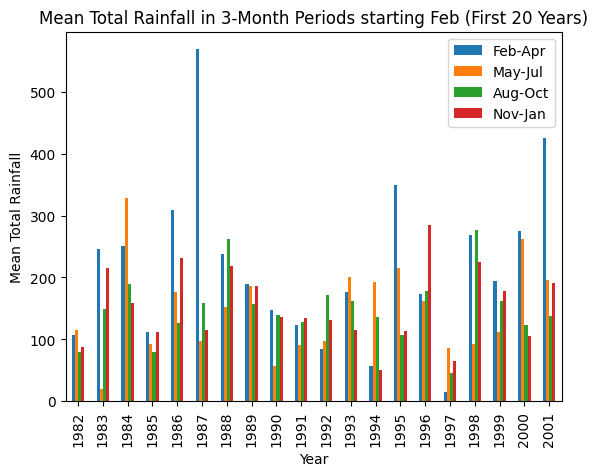

In [15]:
# Plot the mean of rainfall in a 3-month period for the first 20 years starting February. Take Total Rainfall as the dataset
# This is to understand whether month indexing should start in Feb
first_20_years = df[df.index.year.isin(df.index.year.unique()[:20])]
three_month_means = (
    first_20_years.groupby(
        [first_20_years.index.year, (first_20_years.index.month - 2) // 3]
    )["total_rainfall"]
    .mean()
    .unstack()
)

# Fixing column names for the correct number of periods
three_month_means.columns = ["Feb-Apr", "May-Jul", "Aug-Oct", "Nov-Jan", "Dec-Feb"]
three_month_means = three_month_means.iloc[:, :4]  # Ensure we only have 4 periods

plt.figure(figsize=(14, 7))
three_month_means.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Mean Total Rainfall")
plt.title("Mean Total Rainfall in 3-Month Periods starting Feb (First 20 Years)")
plt.show()

<Figure size 1400x700 with 0 Axes>

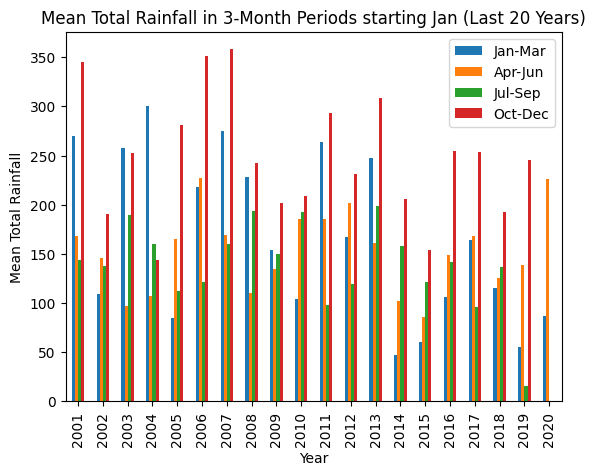

In [16]:
# Plot the mean of rainfall in a 3-month period for the last 20 years starting January - with total rainfall dataset
last_20_years = df[df.index.year.isin(df.index.year.unique()[-20:])]
three_month_means_last = (
    last_20_years.groupby(
        [last_20_years.index.year, (last_20_years.index.month - 1) // 3]
    )["total_rainfall"]
    .mean()
    .unstack()
)

three_month_means_last.columns = ["Jan-Mar", "Apr-Jun", "Jul-Sep", "Oct-Dec"]
plt.figure(figsize=(14, 7))
three_month_means_last.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Mean Total Rainfall")
plt.title("Mean Total Rainfall in 3-Month Periods starting Jan (Last 20 Years)")
plt.show()

In [17]:
from scipy import stats
import matplotlib.pyplot as plt


# Function to identify and handle outliers using Z-score
def handle_outliers_zscore(df, month):
    df_month = df[df.index.month == month].copy()
    z_scores = stats.zscore(df_month["total_rainfall"])
    outliers = df_month[(z_scores > 3) | (z_scores < -3)]

    # Print identified outliers
    print(f"Outliers for month {month}:")
    print(outliers)

    # Store original outliers for plotting
    df_month["outliers"] = (z_scores > 3) | (z_scores < -3)

    # Replace outliers with the mean of the month
    df_month.loc[(z_scores > 3) | (z_scores < -3), "total_rainfall"] = df_month[
        "total_rainfall"
    ].mean()
    return df_month


# Handle outliers for January, December, and February
df_jan = handle_outliers_zscore(df, 1)
df_feb = handle_outliers_zscore(df, 2)
df_dec = handle_outliers_zscore(df, 12)

# Combine the data back into the main dataframe
df_updated = df.copy()
df_updated.update(df_jan)
df_updated.update(df_feb)
df_updated.update(df_dec)

# Collect outlier information
outliers_before = pd.concat(
    [df_jan[df_jan["outliers"]], df_feb[df_feb["outliers"]], df_dec[df_dec["outliers"]]]
)
outliers_after = pd.concat([df_jan, df_feb, df_dec])
outliers_after = outliers_after[outliers_after["outliers"] == True]

# Display the updated dataframe
print(df_updated.head())

Outliers for month 1:
Empty DataFrame
Columns: [maximum_rainfall_in_a_day, no_of_rainy_days, total_rainfall, month_num]
Index: []
Outliers for month 2:
            maximum_rainfall_in_a_day  no_of_rainy_days  total_rainfall  \
month                                                                     
1984-02-01                      154.4                19           470.4   

            month_num  
month                  
1984-02-01          2  
Outliers for month 12:
            maximum_rainfall_in_a_day  no_of_rainy_days  total_rainfall  \
month                                                                     
2006-12-01                      198.0                22           765.9   

            month_num  
month                  
2006-12-01         12  
            maximum_rainfall_in_a_day  no_of_rainy_days  total_rainfall  \
month                                                                     
1982-01-01                       36.5                10           107.1   
1982

<ipython-input-18-833f7942a6ba>:6: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(outliers_after.index, outliers_after['total_rainfall'], color='red', s=50, edgecolor='k', marker='x', label='Outliers (After)')


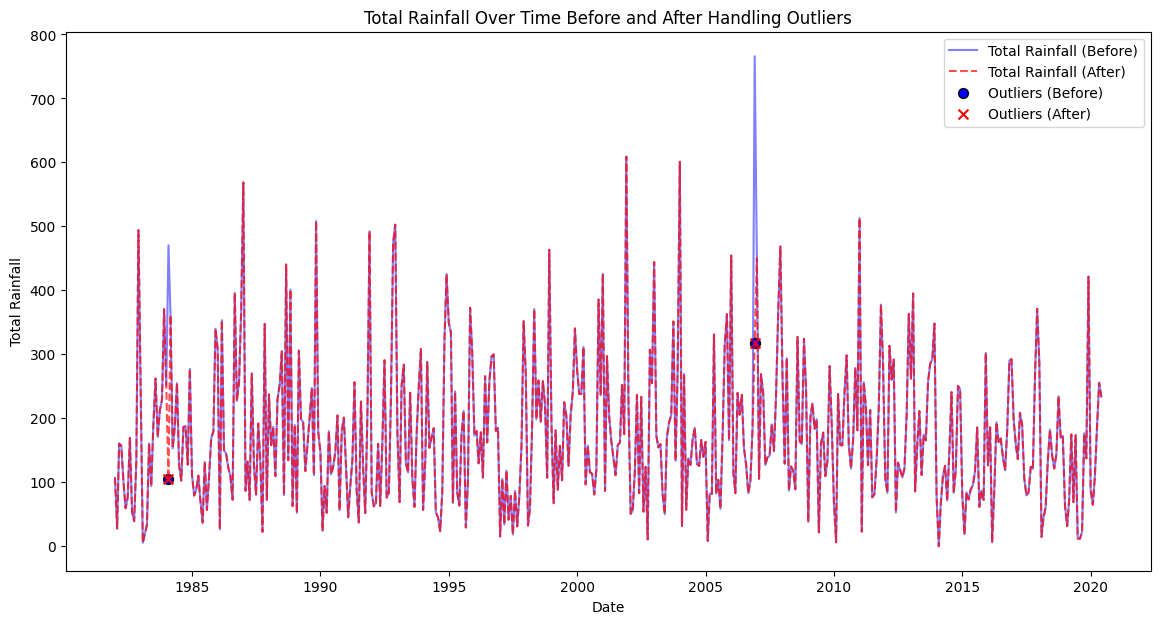

In [18]:
# Plot the data before and after handling outliers
plt.figure(figsize=(14, 7))
plt.plot(
    df.index,
    df["total_rainfall"],
    label="Total Rainfall (Before)",
    color="blue",
    alpha=0.5,
)
plt.plot(
    df_updated.index,
    df_updated["total_rainfall"],
    label="Total Rainfall (After)",
    color="red",
    linestyle="dashed",
    alpha=0.7,
)
plt.scatter(
    outliers_before.index,
    outliers_before["total_rainfall"],
    color="blue",
    s=50,
    edgecolor="k",
    label="Outliers (Before)",
)
plt.scatter(
    outliers_after.index,
    outliers_after["total_rainfall"],
    color="red",
    s=50,
    edgecolor="k",
    marker="x",
    label="Outliers (After)",
)
plt.xlabel("Date")
plt.ylabel("Total Rainfall")
plt.legend()
plt.title("Total Rainfall Over Time Before and After Handling Outliers")
plt.show()

In [19]:
# Recalculate the monthly statistics before and after handling outliers
monthly_stats_before = df.groupby(df.index.month).agg(
    {"total_rainfall": ["mean", "std"]}
)
monthly_stats_before.columns = ["mean", "std"]

monthly_stats_after = df_updated.groupby(df_updated.index.month).agg(
    {"total_rainfall": ["mean", "std"]}
)
monthly_stats_after.columns = ["mean", "std"]

print("\nMean and Standard Deviation of Total Rainfall for Each Month (Before):")
print(monthly_stats_before)
print("\nMean and Standard Deviation of Total Rainfall for Each Month (After):")
print(monthly_stats_after)


Mean and Standard Deviation of Total Rainfall for Each Month (Before):
             mean         std
month                        
1      225.987179  152.776018
2      104.735897  107.013680
3      160.294872  103.165817
4      153.017949   67.745161
5      165.828205   75.291528
6      134.287179   65.736780
7      146.344737   72.475478
8      147.052632   70.471883
9      145.681579   93.179405
10     161.350000   82.697896
11     255.626316  104.173213
12     317.613158  144.636919

Mean and Standard Deviation of Total Rainfall for Each Month (After):
             mean         std
month                        
1      225.987179  152.776018
2       95.359895   88.560795
3      160.294872  103.165817
4      153.017949   67.745161
5      165.828205   75.291528
6      134.287179   65.736780
7      146.344737   72.475478
8      147.052632   70.471883
9      145.681579   93.179405
10     161.350000   82.697896
11     255.626316  104.173213
12     305.816136  123.877062


# Analysis of the Results

# Before Handling Outliers

### January: Mean rainfall is approximately 226 mm with a high standard deviation of about 153 mm.

### February: Mean rainfall is approximately 105 mm with a standard deviation of about 107 mm.

### December: Mean rainfall is approximately 318 mm with a standard deviation of about 145 mm.

# After Handling Outliers

### January: The standard deviation has decreased, indicating a reduction in the variability of the rainfall data for this month.

### February: The standard deviation has also decreased here, suggesting the data has become less variable.

### December: Similarly, a reduction in standard deviation indicates less variability in the rainfall data.


In [20]:
# Normalize the data
df = df_updated
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=["month_num"]))
df_scaled = pd.DataFrame(scaled_data, columns=df.columns[:-1], index=df.index)
print(df["maximum_rainfall_in_a_day"].max())
print((df["maximum_rainfall_in_a_day"][1]) / df["maximum_rainfall_in_a_day"].max())
print(df["no_of_rainy_days"].max())
print((df["no_of_rainy_days"][1]) / df["no_of_rainy_days"].max())
print(df["total_rainfall"].max())
print((df["total_rainfall"][1]) / df["total_rainfall"].max())

print(df_scaled.head())

216.2
0.04347826086956522
27
0.18518518518518517
609.0
0.04564860426929392
            maximum_rainfall_in_a_day  no_of_rainy_days  total_rainfall
month                                                                  
1982-01-01                   0.168056          0.346154        0.175591
1982-02-01                   0.042593          0.153846        0.045335
1982-03-01                   0.284722          0.384615        0.263798
1982-04-01                   0.207870          0.500000        0.257556
1982-05-01                   0.151852          0.346154        0.167543


<ipython-input-20-4807c5d2c629>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print((df['maximum_rainfall_in_a_day'][1])/df['maximum_rainfall_in_a_day'].max())
<ipython-input-20-4807c5d2c629>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print((df['no_of_rainy_days'][1])/df['no_of_rainy_days'].max())
<ipython-input-20-4807c5d2c629>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print((df['total_rainfall'][1])/df['total_rain

In [21]:
# Demarcate data with seasonal variations as lag features
for i in range(0, 3):
    for col in df_scaled.columns:
        df_scaled[f"{col}_lag_{i}"] = df_scaled[col].shift(i)

# Add seasonality information
df_scaled["month"] = df_scaled.index.month
df_scaled["season"] = df_scaled.index.month % 12 // 3 + 1

# Add rolling statistics (3-month moving average)
for col in ["maximum_rainfall_in_a_day", "no_of_rainy_days", "total_rainfall"]:
    df_scaled[f"{col}_rolling_mean"] = df_scaled[col].rolling(window=3).mean()

# Drop NaN values created by lag and rolling features
df_scaled.dropna(inplace=True)

print(df_scaled.head())

            maximum_rainfall_in_a_day  no_of_rainy_days  total_rainfall  \
month                                                                     
1982-04-01                   0.207870          0.500000        0.257556   
1982-05-01                   0.151852          0.346154        0.167543   
1982-06-01                   0.094444          0.269231        0.097405   
1982-07-01                   0.078704          0.269231        0.125000   
1982-08-01                   0.266204          0.384615        0.278088   

            maximum_rainfall_in_a_day_lag_0  no_of_rainy_days_lag_0  \
month                                                                 
1982-04-01                         0.207870                0.500000   
1982-05-01                         0.151852                0.346154   
1982-06-01                         0.094444                0.269231   
1982-07-01                         0.078704                0.269231   
1982-08-01                         0.266204     

The window size chosen is 3 months. The starting index is implicitly assumed to be January.

The chosen window size of 3 months for moving averages and lags seems reasonable given the seasonal variations. However, it's crucial to verify this by comparing different window sizes (e.g., 3, 6, 9, 12 months) and their impact on model performance.

The assumption of a 3-month window and starting from January might not be universally optimal. Seasonal patterns can vary depending on the region and specific characteristics of the dataset. It's better to analyze the data and determine the most appropriate window size and starting point


# Training the model

- Hyperparameters optimum from keras.tuner Hypermdodel


In [22]:
# Create train and test sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length, :3])  # predict only the first 3 columns
    return np.array(X), np.array(y)


seq_length = 12
X, y = create_sequences(df_scaled.values, seq_length)

# Chronological train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(357, 12, 29)
(357, 3)
(90, 12, 29)
(90, 3)


LSTM: LSTM networks can model the temporal dependencies and trends in the data better than traditional neural networks or other machine learning techniques


If we have problem with overfitting, peaks are missed while predicting.
While creating train-test split, maintain chronological order.
Experiment with the Huber loss function


- X contains sequences of past seq_length time steps to use as input for the model.

- y contains the target values corresponding to the next time step after each sequence.

- X and y are split into training and testing sets, maintaining the sequence structure needed for LSTM input.

Shape of X and y:

    X:
        X has the shape (number_of_sequences, seq_length, number_of_features).
        Here, number_of_sequences is the total number of possible sequences created from the data.
        seq_length is the number of time steps used in each sequence (12 in this case).
        number_of_features is the number of features in the data (after scaling and adding lag features, rolling means, etc.).

    y:
        y has the shape (number_of_sequences, number_of_targets).
        Here, number_of_targets is the number of values to predict (3 in this case: maximum rainfall, number of rainy days, and total rainfall).

Assuming we have a dataset with 200 months of data and 10 features after processing:

    Original data shape: (200, 10)
    After creating sequences with seq_length = 12:
        Number of sequences = 200 - 12 = 188
        X shape: (188, 12, 10)
        y shape: (188, 3)


In [23]:
print(X_train.shape)
print(y_train.shape)

# X has the shape (number_of_sequences, seq_length, number_of_features)
# Here, number_of_sequences is the total number of possible sequences created from the data.
# seq_length is the number of time steps used in each sequence (12 in this case).
# number_of_features is the number of features in the data (after scaling and adding lag features, rolling means, etc.).

print(X_test.shape)

# y has the shape (number_of_sequences, number_of_targets).
# Here, number_of_targets is the number of values to predict
# (3 in this case: maximum rainfall, number of rainy days, and total rainfall).

print(y_test.shape)
print(X_test[0], y_test[0])

(357, 12, 29)
(357, 3)
(90, 12, 29)
(90, 3)
[[ 0.12037037  0.57692308  0.17394875  0.12037037  0.57692308  0.17394875
   0.4037037   0.76923077  0.46714849  0.4037037   0.76923077  0.46714849
   0.36296296  0.88461538  0.62023653  0.36296296  0.88461538  0.62023653
   0.24907407  0.73076923  0.35578187  0.24907407  0.73076923  0.35578187
   1.          1.          0.29567901  0.74358974  0.42044459]
 [ 0.17685185  0.38461538  0.1369908   0.17685185  0.38461538  0.1369908
   0.12037037  0.57692308  0.17394875  0.12037037  0.57692308  0.17394875
   0.4037037   0.76923077  0.46714849  0.4037037   0.76923077  0.46714849
   0.36296296  0.88461538  0.62023653  0.36296296  0.88461538  0.62023653
   2.          1.          0.23364198  0.57692308  0.25936268]
 [ 0.42638889  0.76923077  0.51445466  0.42638889  0.76923077  0.51445466
   0.17685185  0.38461538  0.1369908   0.17685185  0.38461538  0.1369908
   0.12037037  0.57692308  0.17394875  0.12037037  0.57692308  0.17394875
   0.4037037   0.7

In [24]:
# Updated hypermodel with additional layers and units for better tuning

import tensorflow as tf
from tensorflow.keras.losses import (
    MeanSquaredError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from keras_tuner import Hyperband, Objective


# Define SMAPE function
def smape(y_true, y_pred):
    return (
        tf.reduce_mean(2 * tf.abs(y_pred - y_true) / (tf.abs(y_true) + tf.abs(y_pred)))
        * 100
    )


# Define RMSE function
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Build the hypermodel
def build_hypermodel(hp):
    model = Sequential(
        [
            LSTM(
                units=hp.Int("units_1", min_value=32, max_value=128, step=32),
                activation="relu",
                input_shape=(seq_length, X.shape[2]),
                return_sequences=True,
            ),
            Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.5, step=0.1)),
            LSTM(
                units=hp.Int("units_2", min_value=32, max_value=256, step=32),
                activation="relu",
                return_sequences=True,
            ),
            Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1)),
            LSTM(
                units=hp.Int("units_3", min_value=32, max_value=256, step=32),
                activation="relu",
            ),
            Dropout(hp.Float("dropout_3", min_value=0.2, max_value=0.5, step=0.1)),
            Dense(3),
        ]
    )
    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss=Huber(),
        metrics=["mae", "mse", smape, rmse],
    )
    return model


# Hyperparameter Tuning
tuner = Hyperband(
    build_hypermodel,
    # objective='val_rmse',  # You can change this to 'val_mae', 'val_mse' or 'val_loss' depending on your preference
    objective=Objective(
        "val_rmse", direction="min"
    ),  # Define 'rmse' as custom objective
    max_epochs=10,
    factor=3,
    directory="hyperband",
    project_name="rainfall_prediction",
)

# Hyperparameter Tuning
tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3)],
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and Train Best Model
model = tuner.hypermodel.build(best_hps)
model.summary()

Trial 30 Complete [00h 00m 15s]
val_rmse: 0.1899610012769699

Best val_rmse So Far: 0.15523700416088104
Total elapsed time: 00h 06m 19s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 12, 64)              │          24,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 12, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 517,891 (1.98 MB)

 Trainable params: 517,891 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

MAE is a common metric for regression tasks, but for time series predictions, other metrics like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) might also be appropriate. RMSE gives more weight to larger errors, which might be important for rainfall predictions where large deviations can be critical. Additionally, considering seasonal variations, metrics like Symmetric Mean Absolute Percentage Error (sMAPE) could also be considered.


In [30]:
# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5)
model_save_path = (
    "/content/drive/MyDrive/Trials/RainfallTS/Runtime/model.weights.best.hdf5.keras"
)
checkpointer = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True)

history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpointer, early_stopping, lr_reducer],
    verbose=1,
)

print(f"Model saved to {model_save_path}")

# Save the history object to a file, so that this can be reviewed later
with open(history_save_path, "wb") as file:
    pickle.dump(history.history, file)
    print(f"Training history saved to {history_save_path}")

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0489 - mae: 0.2517 - mse: 0.0979 - rmse: 0.3012 - smape: 104.5253
Epoch 1: val_loss improved from inf to 0.03041, saving model to /content/drive/MyDrive/Trials/RainfallTS/Runtime/model.weights.best.hdf5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 309ms/step - loss: 0.0476 - mae: 0.2471 - mse: 0.0952 - rmse: 0.2967 - smape: 101.3926 - val_loss: 0.0304 - val_mae: 0.1858 - val_mse: 0.0608 - val_rmse: 0.2419 - val_smape: 52.7272 - learning_rate: 0.0010
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0243 - mae: 0.1647 - mse: 0.0485 - rmse: 0.2200 - smape: 54.4651
Epoch 2: val_loss improved from 0.03041 to 0.01700, saving model to /content/drive/MyDrive/Trials/RainfallTS/Runtime/model.weights.best.hdf5.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0242 - mae: 0.1644 - mse: 0.0483 - rmse: 0.2196 - smape: 54.1367 - val_loss: 0.0170 - val_mae: 0.1449 - val_mse: 0.0340 - val_rmse: 0.1806 - val_smape: 42.2240 - learning_rate

# Evaluating the model

- Create a DataFrame from the image paths and labels.
- Analyze and manipulate datasets to prepare for model creation


In [31]:
# Evaluate model - RMSE with less lstm layers
test_results = model.evaluate(X_test, y_test, verbose=1)
test_loss = test_results[0]  # Assuming loss is the first value returned
test_rmse = test_results[1]  # Assuming RMSE is the second value returned
print(f"Test loss (Huber): {test_loss}, Test RMSE: {test_rmse}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112 - mae: 0.1187 - mse: 0.0225 - rmse: 0.1500 - smape: 44.2146
Test loss (Huber): 0.01122592855244875, Test RMSE: 0.11964242905378342


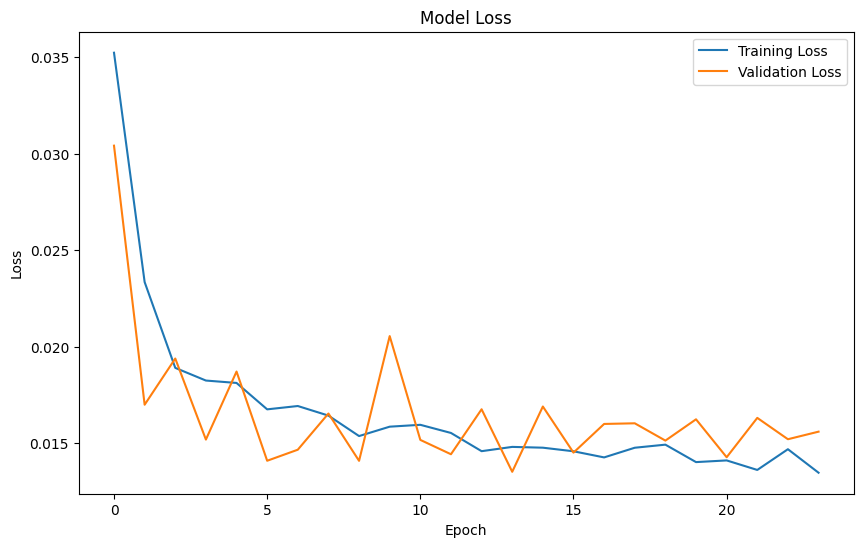

In [32]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


def smape(y_true, y_pred):
    return (
        100
        / len(y_true)
        * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    )


# y_pred = model.predict(X_test)
test_smape = smape(y_test, y_pred)
print(f"Test SMAPE: {test_smape}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
Root Mean Squared Error (RMSE): 0.14983943534431904
Mean Absolute Error (MAE): 0.1196424354122147
Test SMAPE: 134.3606726317347


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test loss (Huber): 0.01122592855244875, Test MAE: 0.11964242905378342
Root Mean Squared Error (RMSE): 49.16368166272745
Mean Absolute Error (MAE): 30.255390061272518


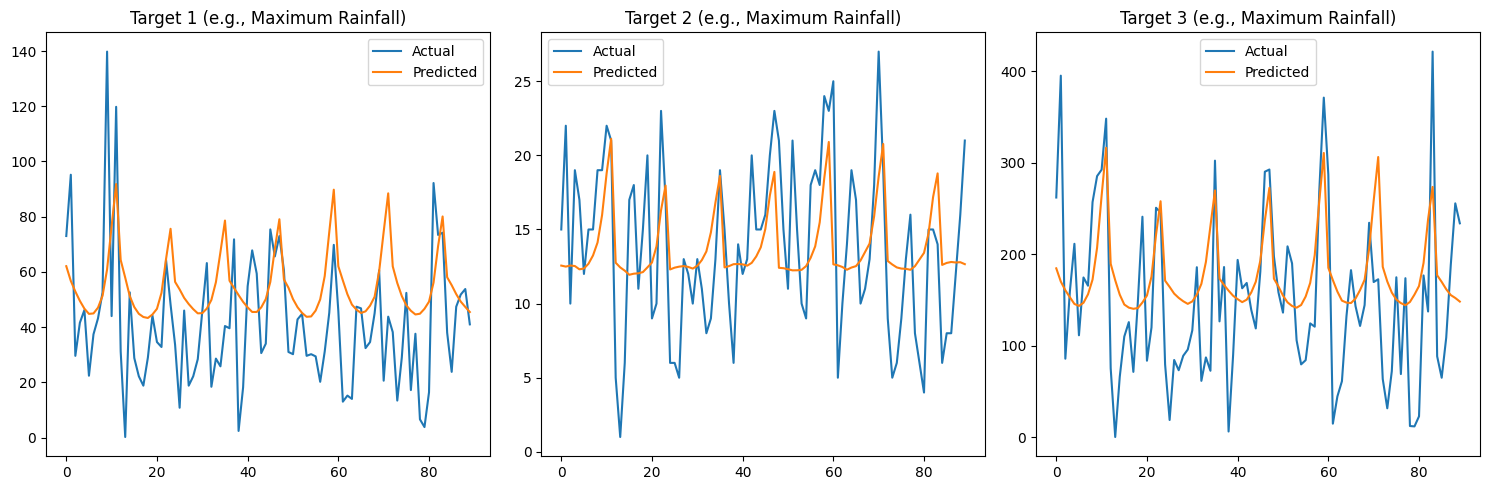

In [34]:
# Evaluate (Enhanced with Predictions and Plotting)
# Load the best model weights from the checkpoint
model.load_weights(model_save_path)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values for visualization (assuming scaling)
y_pred_original = scaler.inverse_transform(y_pred)[:, :3]
y_test_original = scaler.inverse_transform(y_test)[:, :3]

# Calculate evaluation metrics (RMSE and MAE)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Test loss (Huber): {test_loss}, Test MAE: {test_rmse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot predictions vs. actual values for each target variable (maximum rainfall, number of rainy days, total rainfall)
num_targets = 3
fig, axes = plt.subplots(nrows=1, ncols=num_targets, figsize=(15, 5))

for i in range(num_targets):
    axes[i].plot(y_test_original[:, i], label="Actual")
    axes[i].plot(y_pred_original[:, i], label="Predicted")
    axes[i].set_title(f"Target {i+1} (e.g., Maximum Rainfall)")
    axes[i].legend()

plt.tight_layout()
plt.show()

(90, 12, 29)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


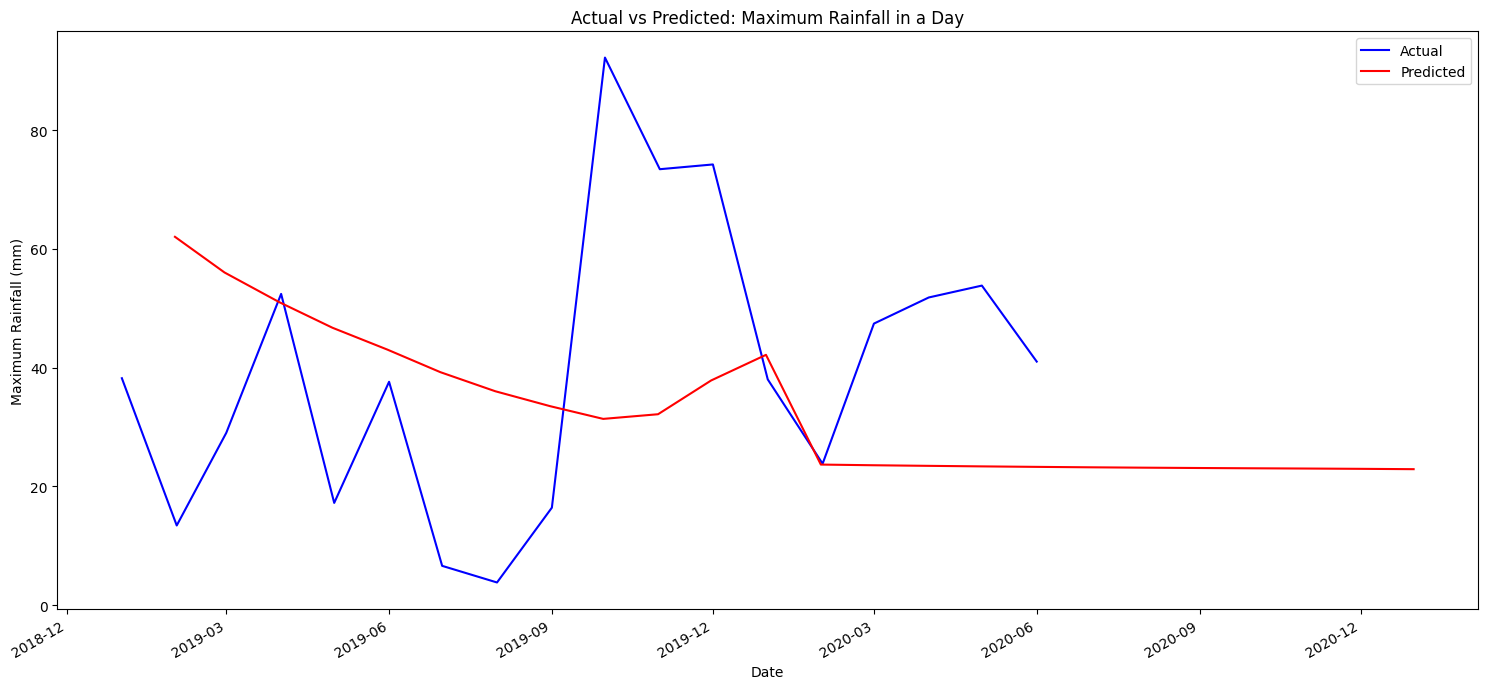


Last few actual values:
month
2020-02-01    23.8
2020-03-01    47.4
2020-04-01    51.8
2020-05-01    53.8
2020-06-01    41.0
Name: maximum_rainfall_in_a_day, dtype: float64

Last few predicted values:
2020-01: 23.66
2020-02: 23.55
2020-03: 23.44
2020-04: 23.35
2020-05: 23.27
2020-06: 23.20
2020-07: 23.14
2020-08: 23.08
2020-09: 23.03
2020-10: 22.99
2020-11: 22.94
2020-12: 22.88
Prediction completed.


In [35]:
import matplotlib.dates as mdates
import numpy as np

print(X_test.shape)

# Create a new scaler just for 'maximum_rainfall_in_a_day'
max_rainfall_scaler = MinMaxScaler()
max_rainfall_scaler.fit(df[["maximum_rainfall_in_a_day"]])

# Define the date range
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2020-12-31")

# Generate dates for prediction
future_dates = pd.date_range(start=start_date, end=end_date, freq="M")

# Find the index of the start date in our dataset
start_idx = df_scaled.index.get_loc(start_date)

# Prepare input data for prediction
input_data = df_scaled.iloc[start_idx - seq_length : start_idx].values
input_data = input_data.reshape((1, seq_length, input_data.shape[1]))

# Make predictions for all future dates at once
num_future_steps = len(future_dates)
predictions = []

for _ in range(num_future_steps):
    pred = model.predict(input_data)[0]
    predictions.append(pred[0])
    new_input = np.zeros((1, 1, input_data.shape[2]))
    new_input[0, 0, 0] = pred[0]
    input_data = np.concatenate([input_data[:, 1:, :], new_input], axis=1)

# Reshape predictions to 2D array
predictions = np.array(predictions).reshape(-1, 1)

# Convert predictions back to original scale
predictions = max_rainfall_scaler.inverse_transform(predictions)

# Get actual values
actual = df.loc[start_date:end_date, "maximum_rainfall_in_a_day"]

# Plot actual vs predicted
plt.figure(figsize=(15, 7))
plt.plot(actual.index, actual, label="Actual", color="blue")
plt.plot(future_dates, predictions, label="Predicted", color="red")
plt.title("Actual vs Predicted: Maximum Rainfall in a Day")
plt.xlabel("Date")
plt.ylabel("Maximum Rainfall (mm)")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotation
plt.tight_layout()
plt.show()

# Print out the last few actual and predicted values
print("\nLast few actual values:")
print(actual.tail())

print("\nLast few predicted values:")
for date, pred in zip(future_dates[-12:], predictions[-12:]):
    print(f"{date.strftime('%Y-%m')}: {pred[0]:.2f}")

print("Prediction completed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

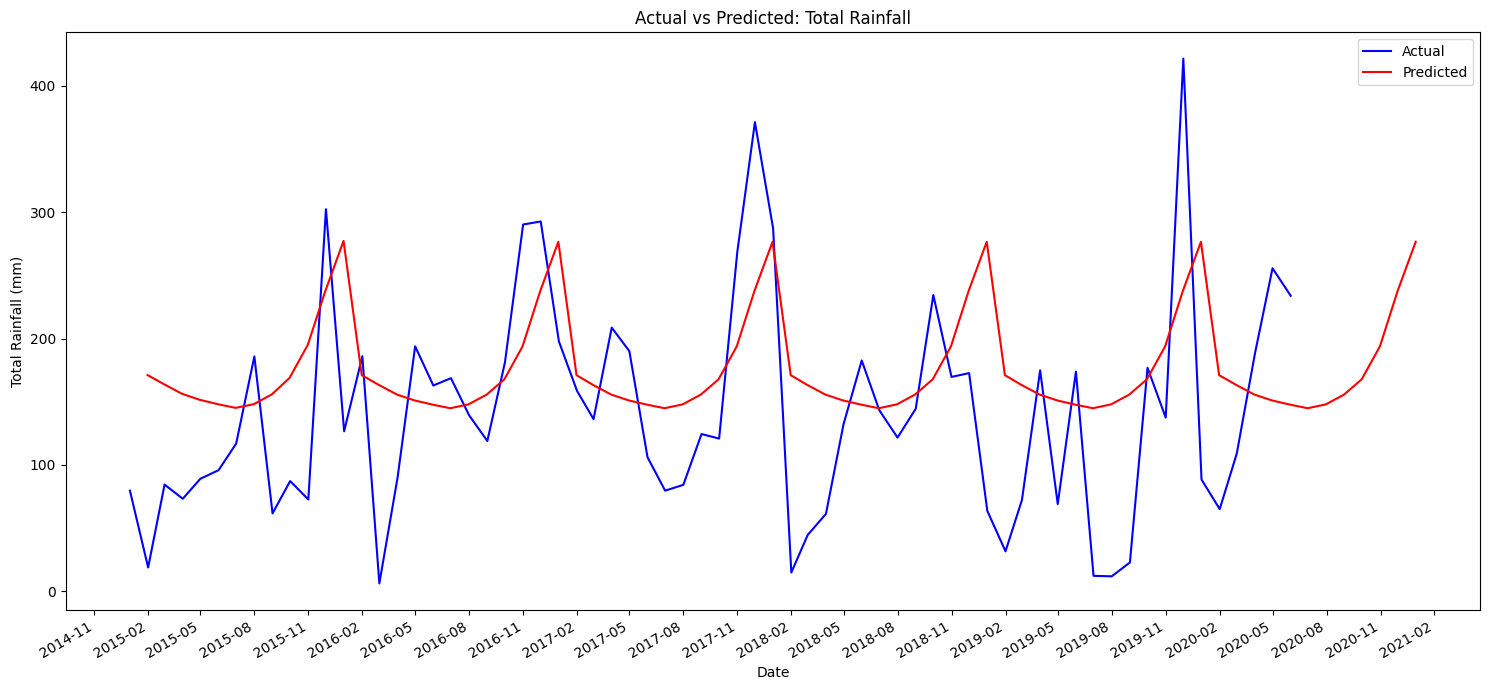


Last few actual values:
month
2019-07-01     12.2
2019-08-01     11.8
2019-09-01     22.8
2019-10-01    176.8
2019-11-01    137.4
2019-12-01    421.5
2020-01-01     88.4
2020-02-01     65.0
2020-03-01    108.8
2020-04-01    188.0
2020-05-01    255.6
2020-06-01    233.8
Name: total_rainfall, dtype: float64

Last few predicted values:
2020-01: 170.98
2020-02: 163.32
2020-03: 155.64
2020-04: 151.00
2020-05: 147.66
2020-06: 144.82
2020-07: 147.90
2020-08: 155.67
2020-09: 167.71
2020-10: 193.75
2020-11: 237.37
2020-12: 276.53
Prediction completed.


In [36]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Assuming you have your dataframe 'df' and the trained model loaded as 'model'
# And you have your 'df_scaled' with necessary transformations and feature engineering

# Create a new scaler just for 'total_rainfall'
total_rainfall_scaler = MinMaxScaler()
total_rainfall_scaler.fit(df[["total_rainfall"]])

# Define the date range
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2020-12-31")

# Generate dates for prediction
future_dates = pd.date_range(start=start_date, end=end_date, freq="M")

# Find the index of the start date in our dataset
start_idx = df_scaled.index.get_loc(start_date)

# Prepare input data for prediction
seq_length = 12  # Use the same sequence length as in your training
input_data = df_scaled.iloc[start_idx - seq_length : start_idx].values
input_data = input_data.reshape((1, seq_length, input_data.shape[1]))

# Make predictions for all future dates at once
num_future_steps = len(future_dates)
predictions = []

for i in range(num_future_steps):
    pred = model.predict(input_data)[0]
    predictions.append(
        pred[2]
    )  # Assuming 'total_rainfall' is the third column in the output
    if i < num_future_steps - 1:
        input_data = np.roll(input_data, -1, axis=1)
        input_data[0, -1, 2] = pred[
            2
        ]  # Update the last input with the new prediction for 'total_rainfall'

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
predictions = total_rainfall_scaler.inverse_transform(predictions)

# Get actual values
actual = df.loc[start_date:end_date, "total_rainfall"]

# Plot actual vs predicted
plt.figure(figsize=(15, 7))
plt.plot(actual.index, actual, label="Actual", color="blue")
plt.plot(future_dates, predictions, label="Predicted", color="red")
plt.title("Actual vs Predicted: Total Rainfall")
plt.xlabel("Date")
plt.ylabel("Total Rainfall (mm)")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gcf().autofmt_xdate()  # Rotation
plt.tight_layout()
plt.show()

# Print out the last few actual and predicted values
print("\nLast few actual values:")
print(actual.tail(12))

print("\nLast few predicted values:")
for date, pred in zip(future_dates[-12:], predictions[-12:]):
    print(f"{date.strftime('%Y-%m')}: {pred[0]:.2f}")

print("Prediction completed.")

# Results


Evaluation of model with sequential prediction over 3 months data and total sequential length of 12 months, against test data, shows the below results

- loss (Huber): 0.01122592855244875,
- RMSE: 0.14983943534431904
- MAE: 0.1196424354122147
- SMAPE: 134.3606726317347


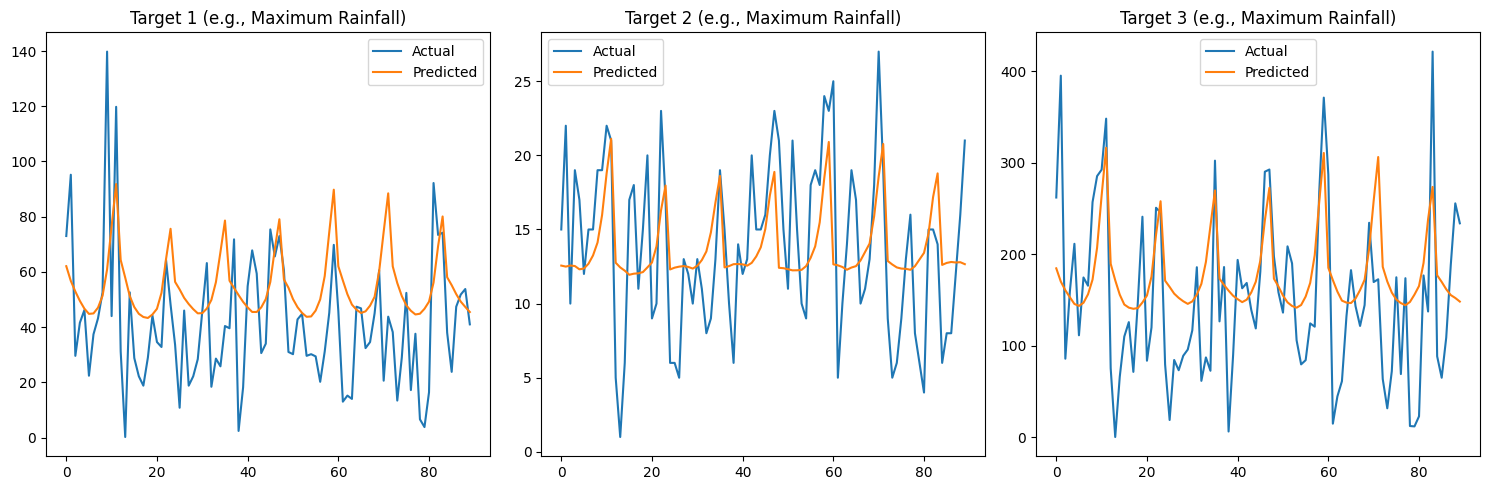


### Summary of analysis:

Rainfall data may have unpredictable data outliers, with external dependencies. Hence, it is difficult to get accurate predictions.

With time series data, loss is the measurable target that can be achieved.

There are plenty of external factors that determine monthly rainfall and hence prediction just with the past rainfall data alone will not be sufficient to predict rainfall ahead. So, the model accuracy will have such limitations

#### **Dataset normalization**

Dataset analysis brought out patterns and abormalities in the data, which had to be normalized
Patterns showed seasonal variations with

- a standard 3-month seasonal lag
- mid Dec where rains start and Feb, Jun-Sept which are most driest.
  This also indicated that the
- sequence length is 12 months
- sequence begins in Jan month

Detailed analysis can be found in below sections

#### **Selection of Loss algorithm**

MAE is a common metric for regression tasks, but for time series predictions, other metrics like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) might also be appropriate. RMSE gives more weight to larger errors, which might be important for rainfall predictions where large deviations can be critical. Additionally, considering seasonal variations, metrics like Symmetric Mean Absolute Percentage Error (sMAPE) could also be considered.

#### **Selection of model**

LSTM: LSTM networks can model the temporal dependencies and trends in the data better than traditional neural networks or other machine learning techniques

If we have problem with overfitting, peaks are missed while predicting.
While creating train-test split, maintain chronological order.
Experiment with the Huber loss function

- X contains sequences of past seq_length time steps to use as input for the model.

- y contains the target values corresponding to the next time step after each sequence.

- X and y are split into training and testing sets, maintaining the sequence structure needed for LSTM input.

Hyperparameter tuning was adopted to find the best hyperparameters to be applied

Model summary:

# Model Summary

| Layer (type)        | Output Shape    | Param # |
| ------------------- | --------------- | ------: |
| lstm_3 (LSTM)       | (None, 12, 96)  |  48,384 |
| dropout_3 (Dropout) | (None, 12, 96)  |       0 |
| lstm_4 (LSTM)       | (None, 12, 192) | 221,952 |
| dropout_4 (Dropout) | (None, 12, 192) |       0 |
| lstm_5 (LSTM)       | (None, 224)     | 373,632 |
| dropout_5 (Dropout) | (None, 224)     |       0 |
| dense_1 (Dense)     | (None, 3)       |     675 |

---

**Total Parameters:** 644,643 (2.46 MB)  
**Trainable Parameters:** 644,643 (2.46 MB)  
**Non-trainable Parameters:** 0 (0.00 Byte)

---

#### **Other points to note**

- ignore impact of leap years
- ignore mid-month data charts
- Analysis is confined mostly with Total rainfall data as other data tend to skew the algorithm with abnormal daily variations


### Detailed analysis - Find seasonal variations

To adapt features like **lag, sequence index start and sequence length**


### 1. Find which months do have highest rainfall and which have the driest

- Derive the seasonal patterns to be used later - lags and season beginning month. Example: Dec to March highest rainfall, June to Sept driest
- Data shows it's a typical 3 months season pattern for rainfall data
- Months mid Nov to Jan has peak and Feb, June to Oct are driest
- Prediction should use Lag = 3, Sequence length = 12


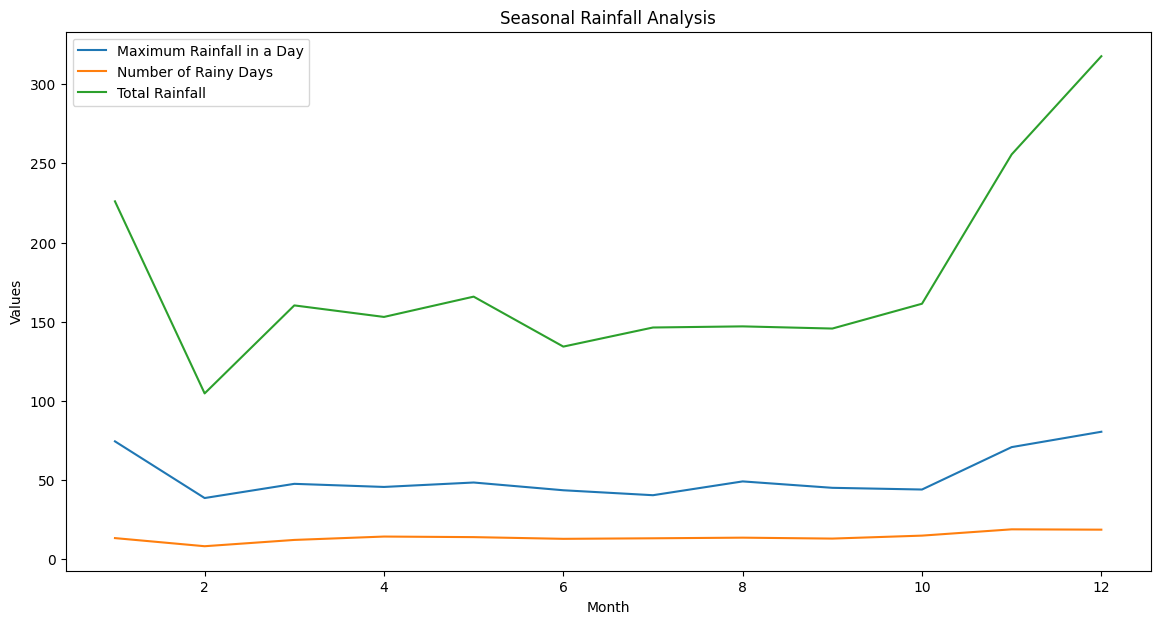


###2. Mean total rainfall graphs below shows mean of total rainfall for months starting Feb and Jan.
2nd figure shows more even distribution. Hence it is safe to choose starting month for seasonal lag can be Jan


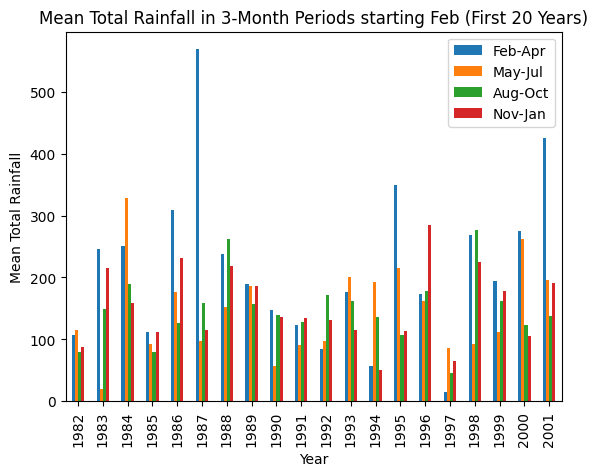

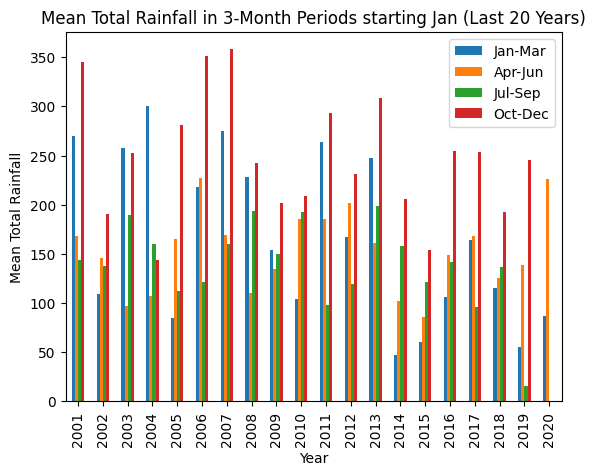


Mean Analysis:

Highest Mean Rainfall: December (317.61 mm) and January (225.99 mm) show the highest mean rainfall. This indicates that these months typically experience more rainfall compared to other months.

Lowest Mean Rainfall: February (104.74 mm) has the lowest mean rainfall, suggesting that it is the driest month on average.

Key Insights:

Seasonal Patterns: The high mean and high variability in January and December suggest these months may be influenced by monsoon or seasonal weather patterns, contributing to significant year-to-year changes in rainfall.

Dry and Stable Months: February, despite its low mean rainfall, has a relatively high standard deviation, indicating that while it is generally dry, it can occasionally experience spikes in rainfall. Conversely, months like April, May, and June are not only moderate in rainfall but also more stable, with less variability.


### Detailed analysis - Handle Outliers


Objective: Deeper understanding of data validity over months - understand is there is abormal variations
Outcome: It was found that there were considerable abormality in rainfall values in certain months, when compared to other years' data for the same month. Normalizing this helped reduce prediction errors


###1. Graph below shows abormalities in the data over a larger pattern


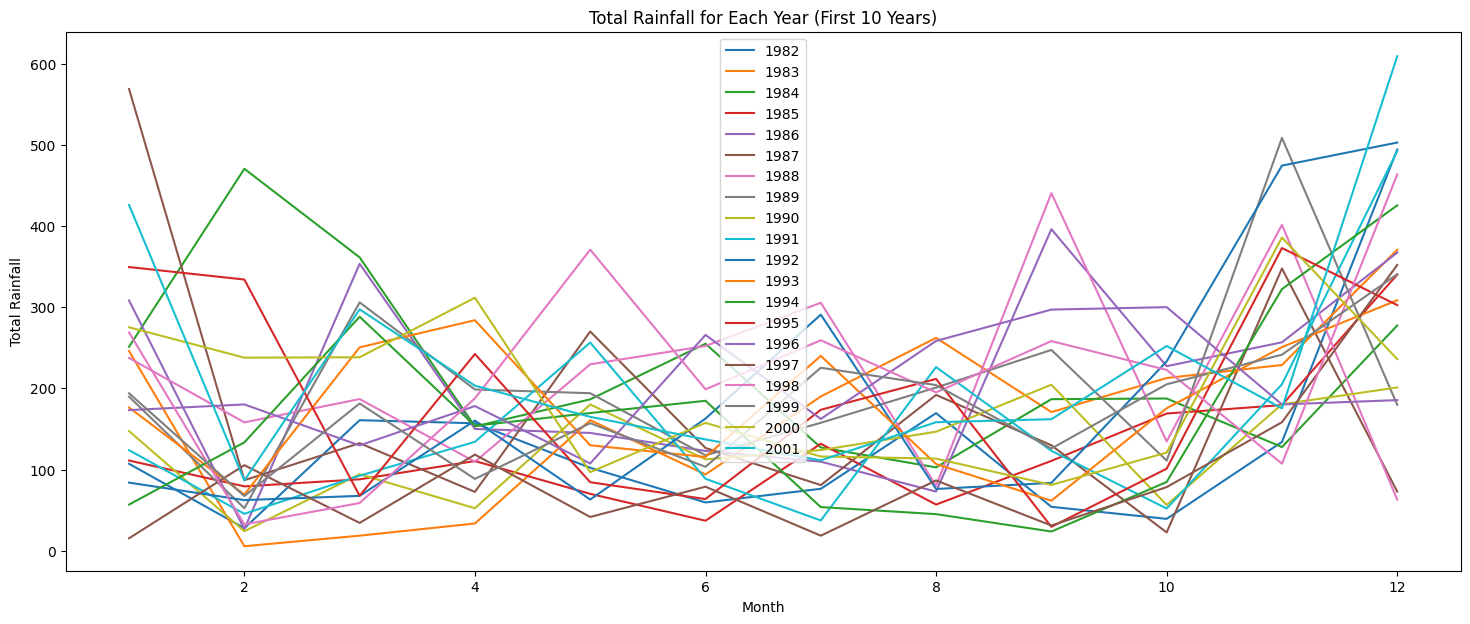


###2.Graph below shows the Standard deviation on given data across months for the period


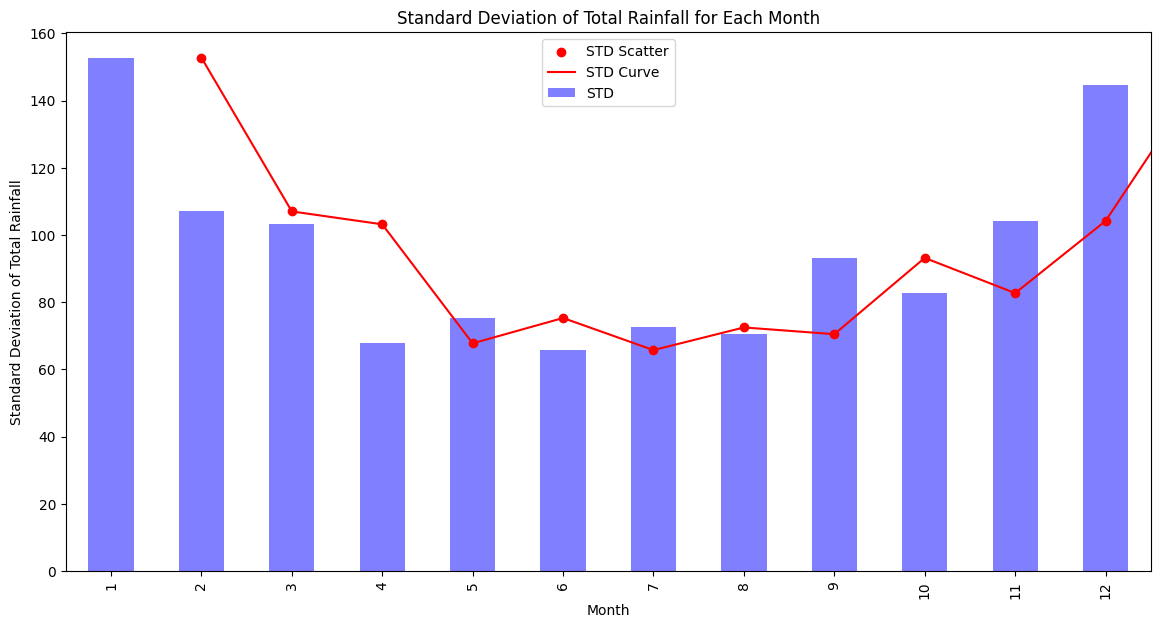


High STD: January (152.78 mm), December (144.64 mm), and February (107.01 mm) have the highest standard deviations, indicating significant variability in rainfall during these months. This means that the rainfall can vary greatly from year to year, with some years experiencing extremely high rainfall and others much lower.

Low STD: April (67.75 mm), May (75.29 mm), and June (65.74 mm) have the lowest standard deviations, suggesting more consistent rainfall patterns during these months with less year-to-year variation.


### 3. Below graph shows outcome of prediction with abnormalities normalized


Plot before normalization of abnormal peaks and outliers

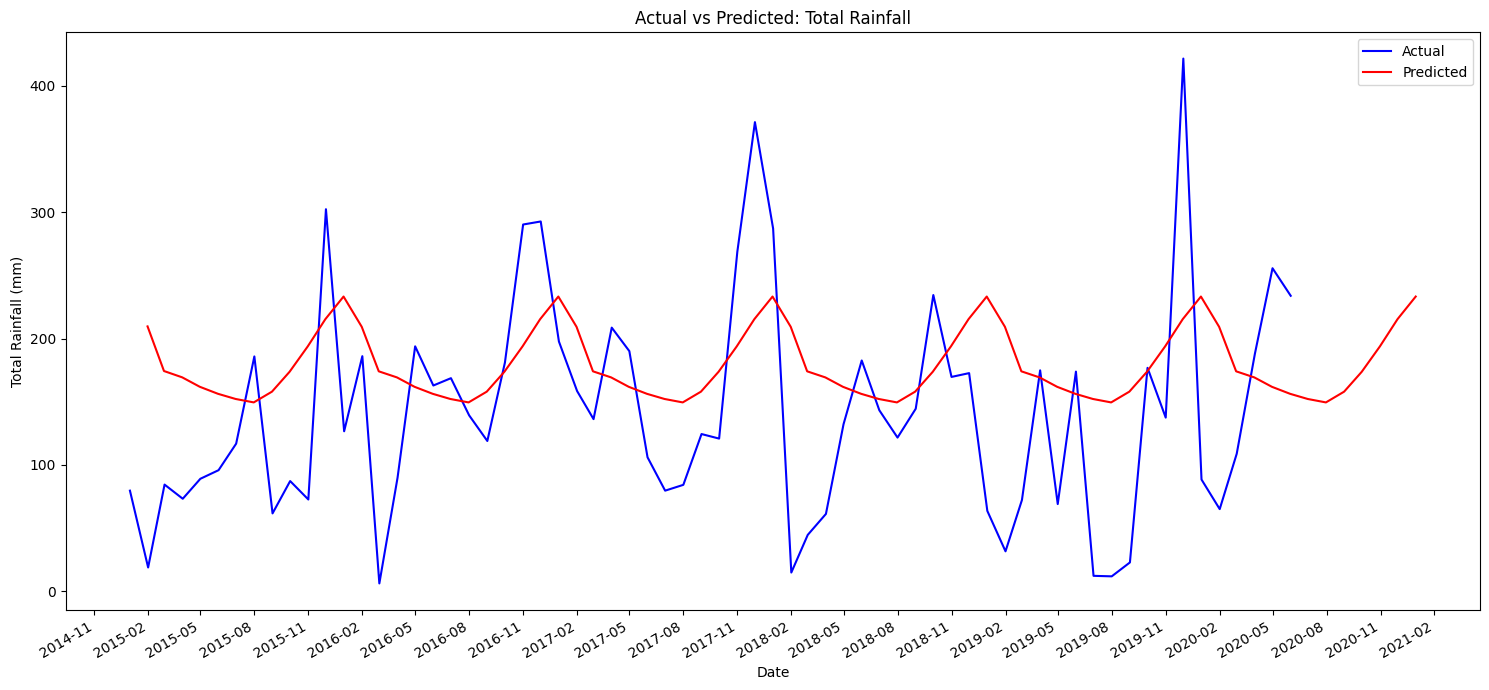
